In [4]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from protein_conformal.scope_utils import calculate_pppl
import torch

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)

# Load the model and tokenizer
model_name = "facebook/esm1b_t33_650M_UR50S" ## this is the backbone ESM model used for CLEAN
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

# Protein sequence
protein_sequence = "MKTIIALSYIFCLVFA"

# Calculate PPPL
pppl = calculate_pppl(model, tokenizer, protein_sequence)
print(f"Pseudo-Perplexity of the sequence: {pppl}")


Pseudo-Perplexity of the sequence: 7.924010276794434


In [1]:
import pandas as pd

new_df = pd.read_csv('data/new_w_pppl.csv', sep = '\t')
price_df = pd.read_csv('data/price_w_pppl.csv', sep = '\t')

new_df.head()

,Entry,EC number,Sequence,PPPL
0,E0VIU9,2.3.2.31,MSILEWFWNILCGMAQYLTFSKNLTNDNLVNIYVKSNVGGTISVNL...,4.857013
1,Q838J7,4.2.1.113,MNIQSIETYQVRLPLKTPFVTSYGRLEEKAFDLFVITDEQGNQGFG...,3.947743
2,P47482,2.7.7.18;3.6.1.41,MKQKIIIFGGSFDPIHNAHLYIAKHAIKKIKAQKLFFVPTYNGIFK...,5.141764
3,B1VB82,2.7.1.177,MAVAQCPASCGELIQGWILGSEKLVSCPVEWYSTVEVTSGSPLTDE...,5.105134
4,R9QMR1,4.2.3.121,MALVSAVPLNSKLCLCRTLFGFSHELKAIHSTVPNLGMCRGGKSIA...,6.792659


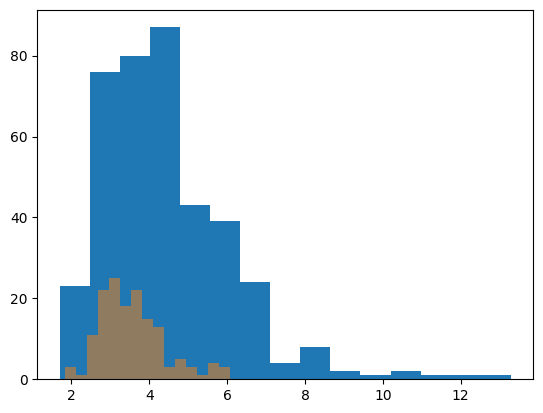

In [2]:
new_pppl = new_df['PPPL']
price_pppl = price_df['PPPL']

## flatten distances from 2d numpy array into 1d and visualize histogram of scores
import matplotlib.pyplot as plt
plt.hist(new_pppl, bins=15, alpha=1, label="new")
plt.hist(price_pppl, bins=15, alpha=0.5, label="price")
plt.show()

In [4]:
import numpy as np
## print out medians, min, max, mean of both flatten arrays
print("Price perplexity median:", np.median(price_pppl))
print("New perplexity median:", np.median(new_pppl))
print("Price perplexity min:", np.min(price_pppl))
print("New perplexity min:", np.min(new_pppl))
print("Price perplexity max:", np.max(price_pppl))
print("New perplexity max:", np.max(new_pppl))
print("Price perplexity mean:", np.mean(price_pppl))
print("New perplexity mean:", np.mean(new_pppl))


Price perplexity median: 3.4154858589172363
New perplexity median: 4.16732382774353
Price perplexity min: 1.8412296772003172
New perplexity min: 1.7051329612731934
Price perplexity max: 6.081921577453613
New perplexity max: 13.28600788116455
Price perplexity mean: 3.5791645162057555
New perplexity mean: 4.437413867639036


In [1]:
import numpy as np
import pickle as pkl

new_near_ids = np.load('clean_new_v_ec_cluster.npy', allow_pickle=True)

price_near_ids = np.load('clean_price_v_ec_cluster.npy', allow_pickle=True)

len(new_near_ids), len(price_near_ids)


(392, 149)

In [7]:
len(new_near_ids[0]['loss'])

5242

In [9]:
new_near_ids[0]['S_i']

array([ 3.14316297,  9.01226902, 10.62465382, ..., 24.22052383,
       24.44428062, 24.9706955 ])

In [49]:
np.array(new_near_ids[0]['loss']) > 1

array([False, False,  True, ...,  True,  True,  True])

In [4]:
def find_first_index_similarity_with_loss_threshold(data_, threshold):
    valid_retrieved_indices, valid_retrieved_sims = [], []
    collision_indices, collision_sims = [], []
    for i, query in enumerate(data_):
        # find index of first element in query['loss'] that is greater than threshold
        idx = np.argmax(np.array(query['loss']) > threshold)
        if idx == 0:
            collision_indices.append(i)
            collision_sims.append(query['S_i'][idx])
        else:
            valid_retrieved_indices.append(i)
            valid_retrieved_sims.append(query['S_i'][idx-1])
            
    return valid_retrieved_indices, valid_retrieved_sims, collision_indices, collision_sims



In [ ]:
alpha_threshold = 1 # find sim of last index that doesn't have a loss greater than threshold
new_last_indices, new_last_sims, new_collision_indices, new_collision_sims = find_first_index_similarity_with_loss_threshold(new_near_ids, alpha_threshold)
price_last_indices, price_last_sims, price_collision_indices, price_collision_sims = find_first_index_similarity_with_loss_threshold(price_near_ids, alpha_threshold)


Text(0.5, 1.0, 'Similarity vs PPPL for New queries where first element loss < 2')

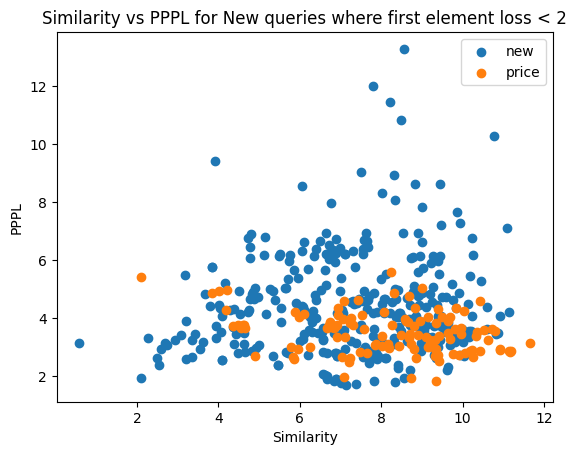

In [62]:
# plot scatterplot of similarity vs perplexity for new and price

plt.scatter(new_last_sims, new_pppl[new_last_indices], label="new")
plt.scatter(price_last_sims, price_pppl[price_last_indices], label="price")
plt.legend()
plt.xlabel("Similarity")
plt.ylabel("PPPL")
plt.title("Similarity vs PPPL for New, Price queries where first element loss <= 1")

Text(0.5, 1.0, 'Similarity vs PPPL for Price queries where first element loss > 1 (failed to retrieve any we want)')

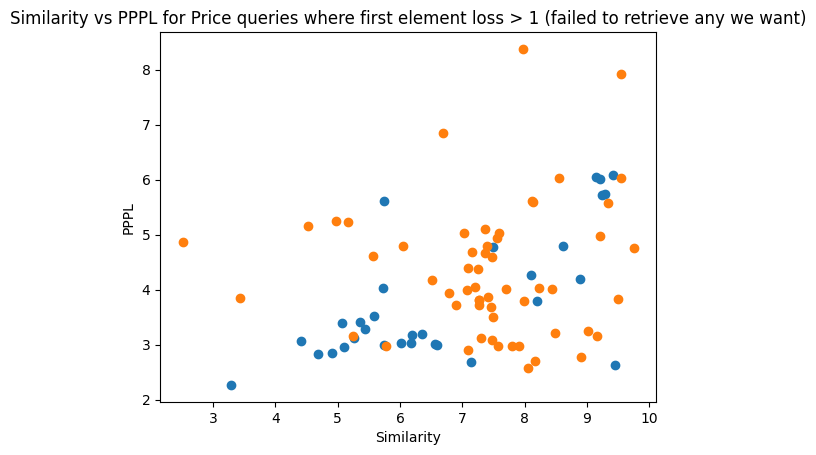

In [63]:
plt.scatter(price_collision_sims, price_pppl[price_collision_indices], label="price")
plt.scatter(new_collision_sims, new_pppl[new_collision_indices], label="new")
plt.xlabel("Similarity")
plt.ylabel("PPPL")
plt.title("Similarity vs PPPL for Price queries where first element loss > 1 (failed to retrieve any we want)")

In [64]:
## compute spearmans for new and price
from scipy.stats import spearmanr
new_spearman = spearmanr(new_last_sims, new_pppl[new_last_indices])
price_spearman = spearmanr(price_last_sims, price_pppl[price_last_indices])
print("New spearman:", new_spearman)
print("Price spearman:", price_spearman)



New spearman: SpearmanrResult(correlation=0.0654152239885027, pvalue=0.23243911675159698)
Price spearman: SpearmanrResult(correlation=-0.2807438490389637, pvalue=0.0020743695972565415)


In [65]:
new_collision_spearman = spearmanr(new_collision_sims, new_pppl[new_collision_indices])
price_collision_spearman = spearmanr(price_collision_sims, price_pppl[price_collision_indices])
print("New collision spearman:", new_collision_spearman)
print("Price collision spearman:", price_collision_spearman)

New collision spearman: SpearmanrResult(correlation=-0.025311942959001785, pvalue=0.8517413144976833)
Price collision spearman: SpearmanrResult(correlation=0.5399193548387098, pvalue=0.001718549439051703)


In [68]:
# compute r^2 for new and price
from sklearn.metrics import r2_score
new_r2 = r2_score(new_last_sims, new_pppl[new_last_indices])
price_r2 = r2_score(price_last_sims, price_pppl[price_last_indices])

print("New r^2:", new_r2)
print("Price r^2:", price_r2)


New r^2: -2.436320268527293
Price r^2: -6.213367830537597


In [69]:
new_collision_r2 = r2_score(new_collision_sims, new_pppl[new_collision_indices])
price_collision_r2 = r2_score(price_collision_sims, price_pppl[price_collision_indices])

print("New collision r^2:", new_collision_r2)
print("Price collision r^2:", price_collision_r2)

New collision r^2: -5.226698194469102
Price collision r^2: -2.296991972304715


### Repeat, but with ESM-1B raw embedding distance-based retrieval

In [3]:
import numpy as np
import pickle as pkl

esm_new_near_ids = np.load('esm_clean_new_v_ec_cluster.npy', allow_pickle=True)

esm_price_near_ids = np.load('esm_clean_price_v_ec_cluster.npy', allow_pickle=True)

len(esm_new_near_ids), len(esm_price_near_ids)


(392, 149)

In [5]:
alpha_threshold = 1 # find sim of last index that doesn't have a loss greater than threshold
esm_new_last_indices, esm_new_last_sims, esm_new_collision_indices, esm_new_collision_sims = find_first_index_similarity_with_loss_threshold(esm_new_near_ids, alpha_threshold)
esm_price_last_indices, esm_price_last_sims, esm_price_collision_indices, esm_price_collision_sims = find_first_index_similarity_with_loss_threshold(esm_price_near_ids, alpha_threshold)


Text(0.5, 1.0, 'ESM Similarity vs PPPL for New, Price queries where first element loss <= 1')

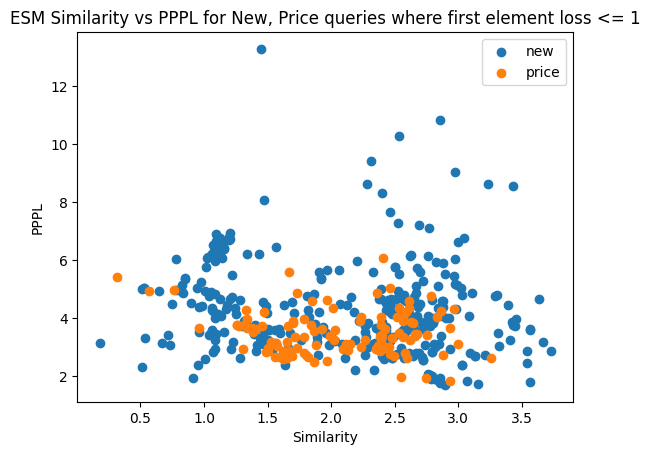

In [6]:
# plot scatterplot of similarity vs perplexity for new and price

plt.scatter(esm_new_last_sims, new_pppl[esm_new_last_indices], label="new")
plt.scatter(esm_price_last_sims, price_pppl[esm_price_last_indices], label="price")
plt.legend()
plt.xlabel("Similarity")
plt.ylabel("PPPL")
plt.title("ESM Similarity vs PPPL for New, Price queries where first element loss <= 1")

Text(0.5, 1.0, 'ESM Similarity vs PPPL for Price queries where first element loss > 1 (failed to retrieve any we want)')

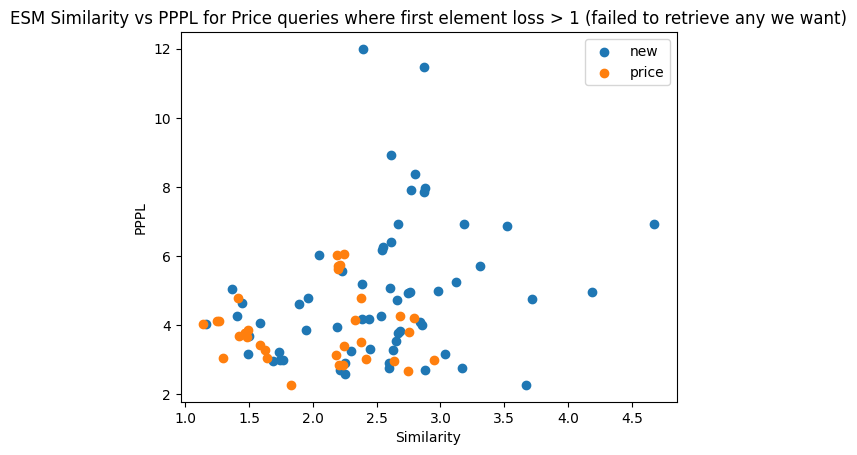

In [11]:
plt.scatter(esm_new_collision_sims, new_pppl[esm_new_collision_indices], label="new")
plt.scatter(esm_price_collision_sims, price_pppl[esm_price_collision_indices], label="price")
plt.xlabel("Similarity")
plt.ylabel("PPPL")
plt.legend()
plt.title("ESM Similarity vs PPPL for Price queries where first element loss > 1 (failed to retrieve any we want)")

In [9]:
from scipy.stats import spearmanr
new_spearman = spearmanr(esm_new_last_sims, new_pppl[esm_new_last_indices])
price_spearman = spearmanr(esm_price_last_sims, price_pppl[esm_price_last_indices])
print("ESM New spearman:", new_spearman)
print("ESM Price spearman:", price_spearman)

new_collision_spearman = spearmanr(esm_new_collision_sims, new_pppl[esm_new_collision_indices])
price_collision_spearman = spearmanr(esm_price_collision_sims, price_pppl[esm_price_collision_indices])
print("ESM New collision spearman:", new_collision_spearman)
print("ESM Price collision spearman:", price_collision_spearman)

ESM New spearman: SpearmanrResult(correlation=-0.21582798565333797, pvalue=7.540782871322004e-05)
ESM Price spearman: SpearmanrResult(correlation=-0.033783108445777116, pvalue=0.718833985912914)
ESM New collision spearman: SpearmanrResult(correlation=0.2964569011105235, pvalue=0.020345239227255233)
ESM Price collision spearman: SpearmanrResult(correlation=-0.11129679144385027, pvalue=0.5374856772874539)


### train RF regressor to predict optimal lambda given embeddings

In [71]:
# Fetch embeddings from CLEAN
## Similar code to the selection methods, except we just want to extract the raw euclidean distance maps for any pair of train and test data
import torch
from CLEAN.utils import * 
from CLEAN.model import LayerNormNet
from CLEAN.distance_map import *
from CLEAN.evaluate import *
import pandas as pd
import warnings

def get_emb(train_data, test_data, pretrained=True, model_name=None):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    dtype = torch.float32
    id_ec_test, _ = get_ec_id_dict('./data/' + test_data + '.csv')
    # load checkpoints
    # NOTE: change this to LayerNormNet(512, 256, device, dtype) 
    # and rebuild with [python build.py install]
    # if inferencing on model trained with supconH loss
    model = LayerNormNet(512, 128, device, dtype)
    
    if pretrained:
        try:
            checkpoint = torch.load('./data/pretrained/'+ train_data +'.pth', map_location=device)
        except FileNotFoundError as error:
            raise Exception('No pretrained weights for this training data')
    else:
        try:
            checkpoint = torch.load('./data/model/'+ model_name +'.pth', map_location=device)
        except FileNotFoundError as error:
            raise Exception('No model found!')
        
    model.load_state_dict(checkpoint)
    model.eval()
    # load precomputed EC cluster center embeddings if possible
        
    emb_test = model_embedding_test(id_ec_test, model, device, dtype)

    return emb_test

In [72]:
test_data = "new"
train_data = "split100"

test_embeddings = get_emb(train_data, test_data, pretrained=True)


In [79]:
len(test_embeddings[new_last_indices]), len(new_pppl[new_last_indices])

(335, 335)

In [110]:
## Train RF Regressor to take in as input the embeddings and PPPL, and predict the optimal similarity to preserve alpha = 1

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# concatenate test_embeddings[new_last_indices], new_pppl[new_last_indices] across axis 1
X = np.concatenate((test_embeddings[new_last_indices].detach().cpu(), np.array(new_pppl[new_last_indices]).reshape(-1,1)), axis=1)

In [111]:
y = new_last_sims

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
## Train RF Regressor

rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MSE: 2.1442483875202356


In [107]:
test_data = "price"
train_data = "split100"

test_price_embeddings = get_emb(train_data, test_data, pretrained=True)


In [108]:
price_X = np.concatenate((test_price_embeddings[price_last_indices].detach().cpu(), np.array(price_pppl[price_last_indices]).reshape(-1,1)), axis=1)

In [109]:
y_pred_price = rf.predict(price_X)

price_mse = mean_squared_error(price_last_sims, y_pred_price)
print("Price MSE:", price_mse)

Price MSE: 4.686859632161763


In [116]:
# train Lasso model to predict sims from embeddings and PPPL
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lasso)
print("Lasso MSE:", mse)


Lasso MSE: 3.413324904822282
